<a href="https://colab.research.google.com/github/robert-bob-1/Image-classification/blob/master/proiect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Load Data

## 1.1 Install Dependencies and Setup


tensorflow used as deep learning pipeline itself (keras sequential pipeline)

opencv to remove dodgy images

matplotlib to visualize statistics

In [1]:
%pip install tensorflow opencv-python matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



### Verify our dependencies

In [2]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.2.0
anyio                        3.7.0
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.2
async-timeout                4.0.2
attrs                        22.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.4
blis                         0.7.9
boltons                      23.0.0
brotlipy                     0.7.0
cachetools                   4.2.2
catalogue                    2.0.8
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           2.0.4
click 

### Import python dependencies
os to navigate through file structure

In [3]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

### Prepare the labels for our classes and initialize image information

In [4]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

### Limit tensorflow using all the power on our GPU (prevent OOM errors)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## 1.2 Load Data

 Load the data:
 
     14,034 images to train the network.

     3,000 images to evaluate how accurately the network learned to classify images.

In [7]:
from zipfile import ZipFile
from PIL import Image
import imghdr

def unzip_data():
    #path to zipped dataset
    # datasetZipPath = 'drive/MyDrive/dataset.zip'
    datasetZipPath = '../dataset.zip'

    # opening the zip file in READ mode
    with ZipFile(datasetZipPath, 'r') as zip:
        # printing all the contents of the zip file
        # zip.printdir()

        print('Extracting all files from zip to local directory...')
        zip.extractall()
        print('Done!')

    return


def load_data():
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category and get images
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
try:
    (train_images, train_labels), (test_images, test_labels) = load_data()
except:
    print('Didn\'t find unzipped data. Trying to unzip file in given zip folder path...')
    unzip_data()
    (train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train/seg_train


100%|████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:01<00:00, 1680.85it/s]


Loading seg_test/seg_test


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 1109.24it/s]


## 1.3 Visualizing and understanding the data

### 1.3.1 Statistics about our data

- How many training and testing examples do we have ?
- What is the size of the images ?
- What is the proportion of each observed category ?

In [10]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


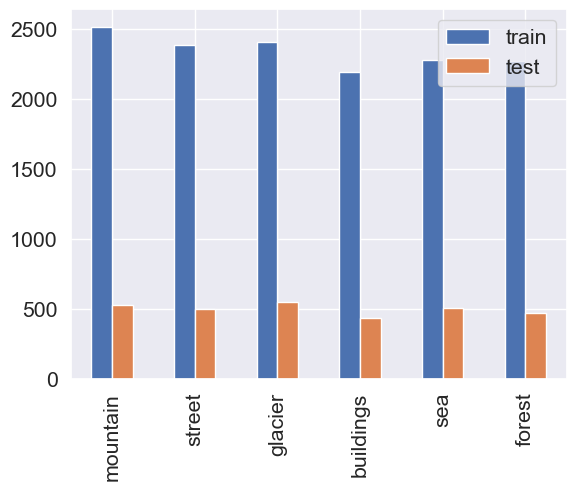

In [11]:
import pandas as pd

# Count each unique category's number of objects
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test' : test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

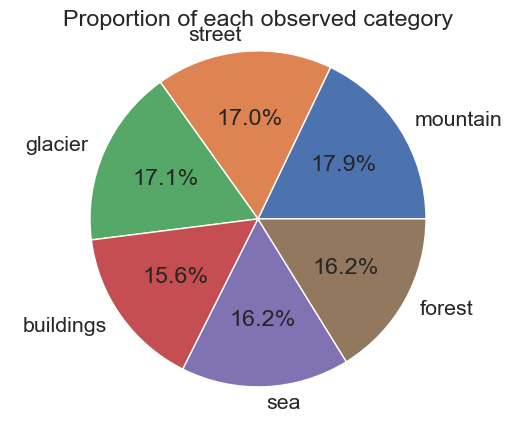

In [12]:
# Based on previously calculated values also create a piechart
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [13]:
# Scale down the pixel data to 0..1 range
train_images = train_images / 255.0 
test_images = test_images / 255.0

### 1.3.2 Visualization of our data

Display a random image from the images array and its correspond label from the labels array.


In [14]:
def display_random_image(class_names, images, labels):    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

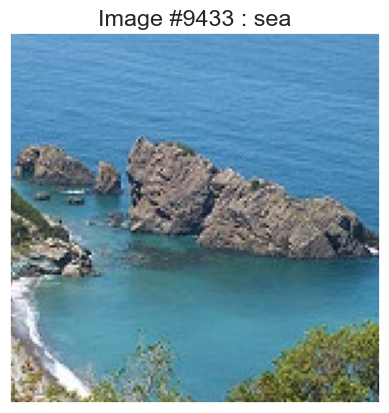

In [15]:
display_random_image(class_names, train_images, train_labels)


Display 25 images from the images array with its corresponding labels


In [16]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[index]])
    plt.show()

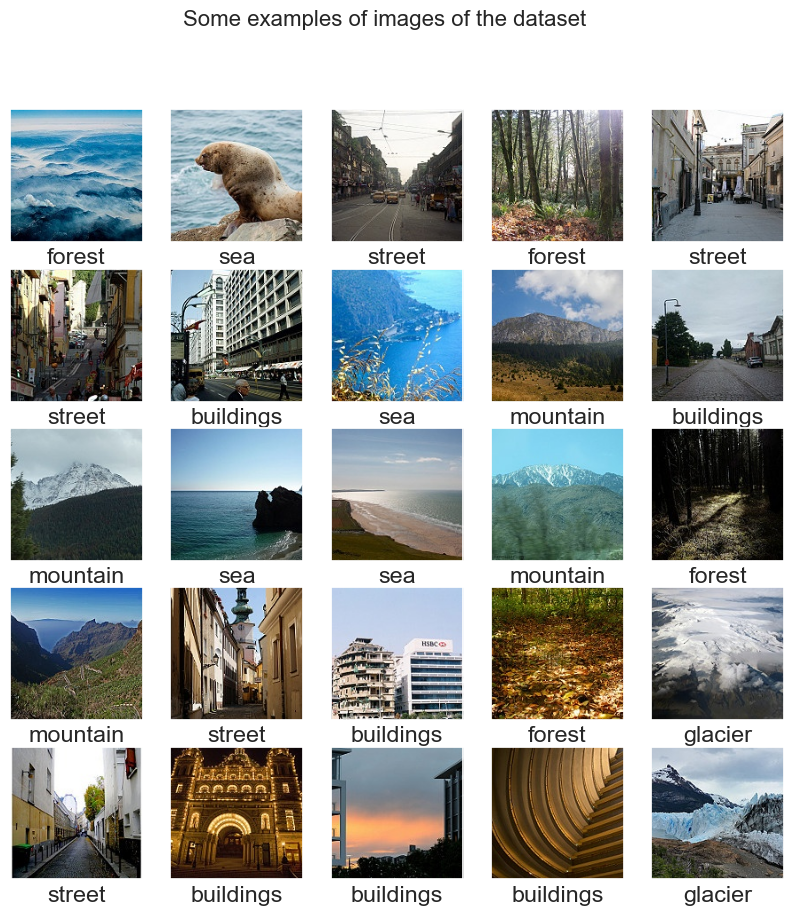

In [17]:
display_examples(class_names, train_images, train_labels)


# 2. Simple Model Creation

Steps are:

1.   Build the model,
2.   Compile the model,
3.   Train / fit the data to the model,
4.   Evaluate the model on the testing set,
5.   Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:

- Conv2D: This layer extracts features by applying 32 filters of size 3x3 over the images.
- MaxPooling2D: This layer performs max pooling, which reduces the size of the input by taking the maximum value within each 2x2 region. Helps us retain essential features while reducing complexity of computations
- Flatten: This layer flattens the output of the previous layer into a 1D array, transforming the multi-dimensional feature maps into a linear representation.
- Relu: Given a value x, returns x if it's positive or else 0.
- Softmax: This layer is a fully connected layer with 6 neurons, representing the probability that the input image belongs to each of the 6 classes. The activation function used is softmax, which provides the probabilities of the different classes, ensuring that the predicted probabilities sum up to 1.

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

We will compile this model with these parameters:
- Optimizer='adam'=RMSProp + Momentum. Momentum takes into account past gradients that have better improvements. RMSProp is a root mean squared average of past gradients
- Loss function was chosen as such since its the standard value for classification where each image belongs only to one class


In [48]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fit the model to the training set.

In [49]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(train_images, train_labels, 32)
test_gen = DataGenerator(test_images, test_labels, 32)


In [50]:
history = model.fit(train_gen, validation_data=test_gen, epochs=5)

Epoch 1/5
439/439 [==============================] - 8s 18ms/step - loss: 1.8394 - accuracy: 0.3131 - val_loss: 1.3665 - val_accuracy: 0.4470
Epoch 2/5
439/439 [==============================] - 8s 17ms/step - loss: 1.2954 - accuracy: 0.4888 - val_loss: 1.2114 - val_accuracy: 0.5180
Epoch 3/5
439/439 [==============================] - 7s 17ms/step - loss: 1.0547 - accuracy: 0.5877 - val_loss: 0.9849 - val_accuracy: 0.6077
Epoch 4/5
439/439 [==============================] - 7s 16ms/step - loss: 0.8418 - accuracy: 0.6770 - val_loss: 0.9649 - val_accuracy: 0.6143
Epoch 5/5
439/439 [==============================] - 7s 16ms/step - loss: 0.6626 - accuracy: 0.7507 - val_loss: 0.8559 - val_accuracy: 0.6893


In [51]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 1s 8ms/step - loss: 0.8559 - accuracy: 0.6893


Let's see how our training went

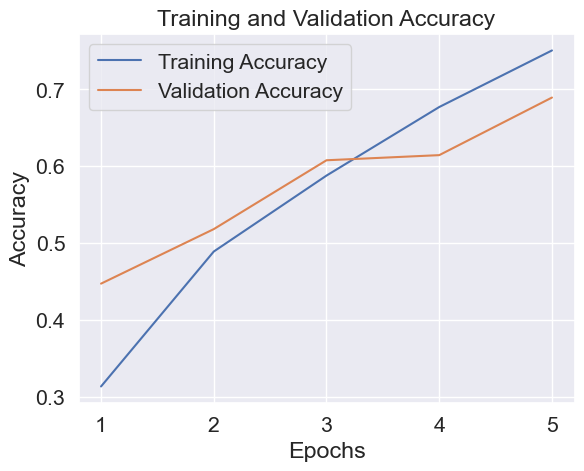

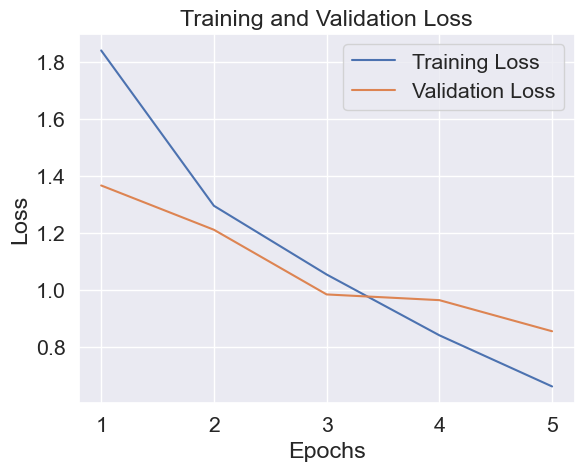

In [52]:
def plot_accuracy_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_accuracy_loss(history)

Underfitting due to only 67% accuracy. Let's test on some random images

94/94 [==============================] - 1s 6ms/step


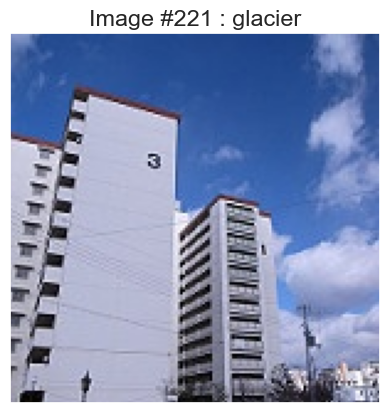

In [53]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

# 3 Error Analysis
Let's try to understand what images are poorly matched.
We will print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels

In [54]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

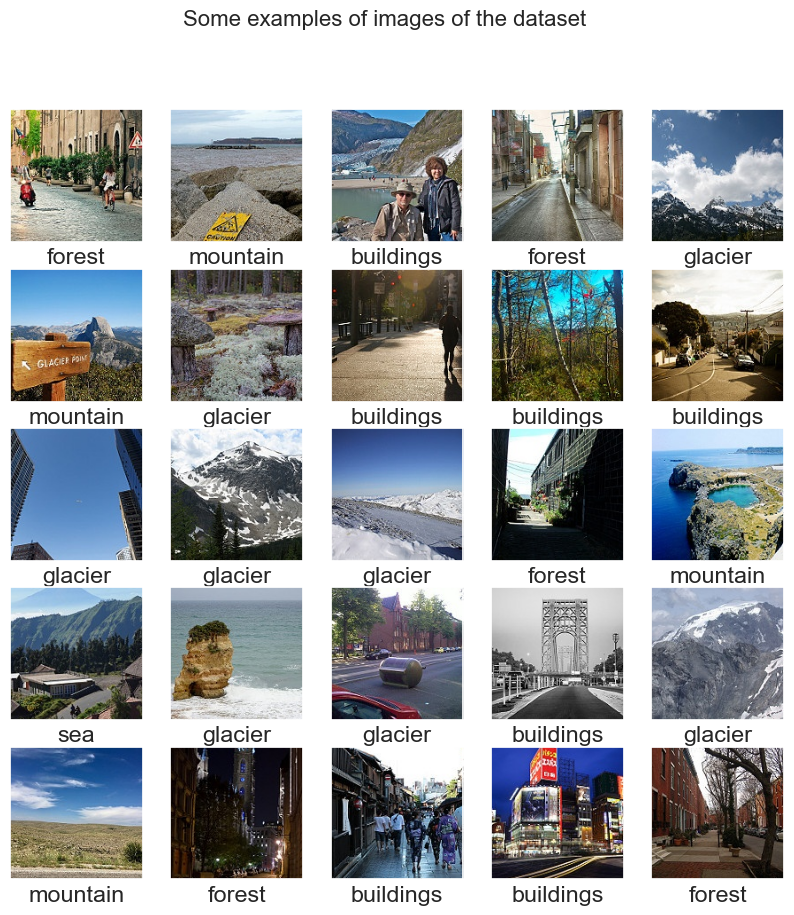

In [55]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Compute confusion matrix to better illustrate how accurate the model is for each class

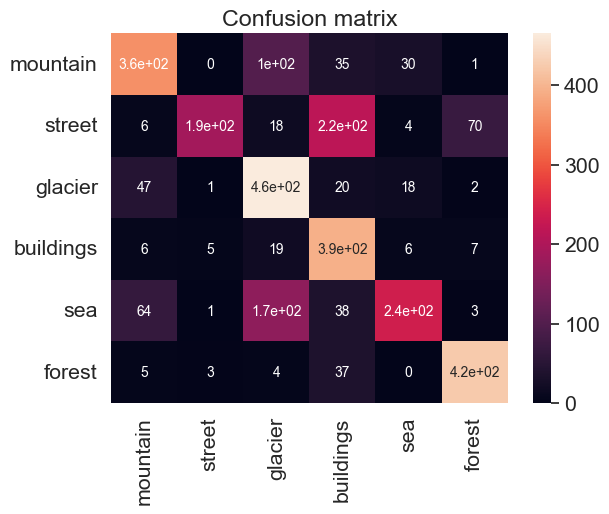

In [56]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

We see our model detects forest and mountains accurately, but
confuses glaciers with mountains, buildings with streets and seas with mountains. 
Often those confusions make sense:
- glaciers are on mountains, 
- buildings in cities have streets near them, 
- and perhaps the sea has repetitive textures similar to mountains along with skies in the picture)

# 4. Generating heat map for a image

In [57]:
# import the necessary packages
# source: https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
from tensorflow.keras.models import Model
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [58]:
img_path = 'seg_test/seg_test/forest/20100.jpg'
#img preprocessing
img = cv2.imread(img_path);
img = img/255
img = np.expand_dims(img, axis=0)
preds = model.predict(img)

# get highest probability
i = np.argmax(preds[0])
print(class_names[i])

1/1 [==============================] - 0s 71ms/step
forest


In [59]:
#compute heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(img)

# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image

#get original img
orig = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

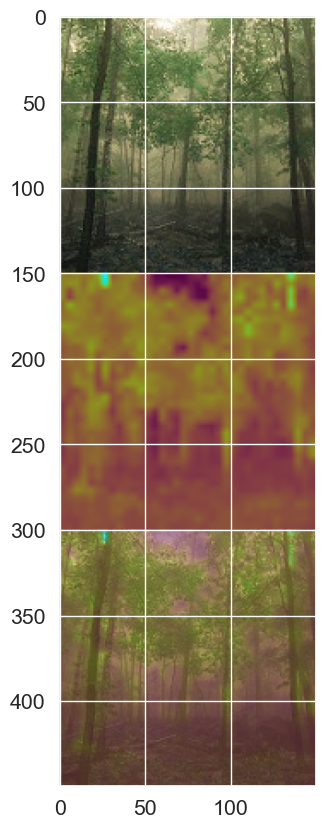

In [60]:
#show result
output = np.vstack([orig, heatmap, output])

fig = plt.figure(figsize=(10,10))
plt.imshow(output, cmap=plt.cm.binary)

# 5. Feature extraction with VGG ImageNet (Transfer Learning)


In [61]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model2 = VGG16(weights='imagenet', include_top=False)

In [62]:
train_features = model2.predict(train_gen)
test_features = model2.predict(test_gen)


94/94 [==============================] - 4s 47ms/step


## 5.1 Visualize the features through PCA (Principal Component Analysis)

In [31]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

Apply PCA using decomposition from scikit

In [32]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # reprezentam
C1 = C[:,0]
C2 = C[:,1]

Show the plot with decomposed features for each class type

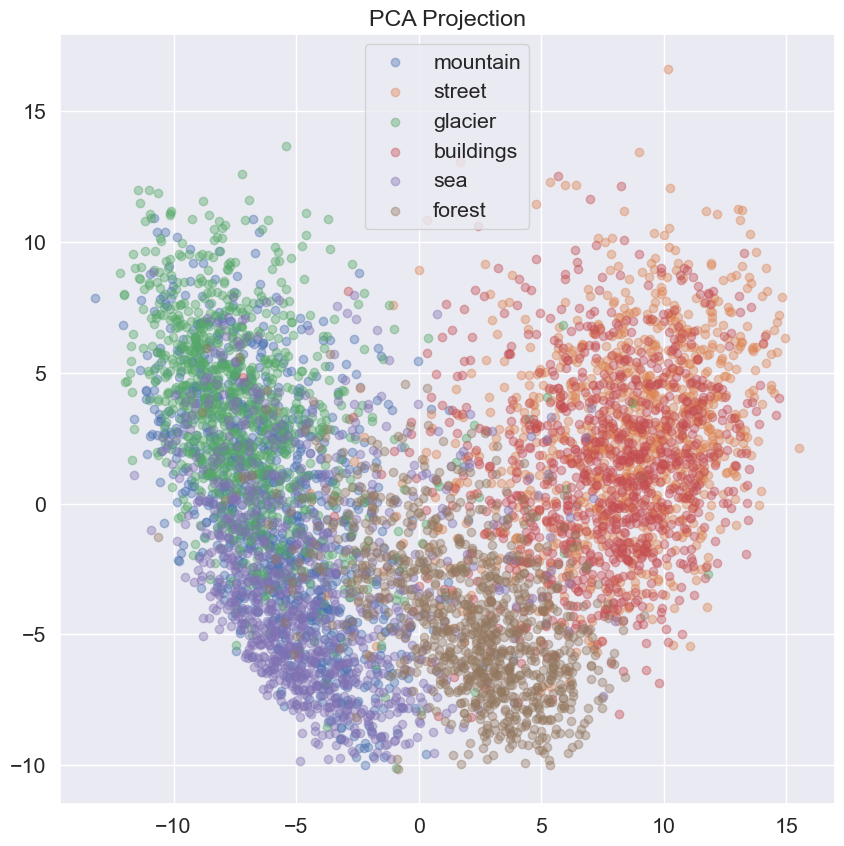

In [33]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

Here we can notice that VGG algorithm classifies glaciers and mountains similarly, as well as streets and buildings.

## 5.2 Training on the features extracted from VGG
Train a simple one-layer NN.

In [34]:
# train the model by adding dense layers on top of extracted features
modelVGG = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4,4,512)), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6, activation='softmax')
])

modelVGG.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2,098,950
Trainable params: 2,098,950
Non-trainable params: 0
_________________________________________________________________


In [35]:
from keras.callbacks import ModelCheckpoint
# compile the model with 'RMSprop' optimizer
modelVGG.compile(loss='sparse_categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )

checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [36]:
# fit the model to datr and save the model statistics to result instance
result = modelVGG.fit(train_features, train_labels,
                   batch_size=128,
                   epochs=10,
                   validation_data=(test_features, test_labels),
                   callbacks=callback_list
                   )


Epoch 1/10
110/110 [==============================] - 2s 12ms/step - loss: 1.1511 - accuracy: 0.5666 - val_loss: 0.6809 - val_accuracy: 0.7980
Epoch 2/10
110/110 [==============================] - 1s 9ms/step - loss: 0.6423 - accuracy: 0.7761 - val_loss: 0.5142 - val_accuracy: 0.8233
Epoch 3/10
110/110 [==============================] - 1s 9ms/step - loss: 0.5271 - accuracy: 0.8135 - val_loss: 0.4550 - val_accuracy: 0.8400
Epoch 4/10
110/110 [==============================] - 1s 9ms/step - loss: 0.4691 - accuracy: 0.8308 - val_loss: 0.4227 - val_accuracy: 0.8457
Epoch 5/10
110/110 [==============================] - 1s 9ms/step - loss: 0.4312 - accuracy: 0.8498 - val_loss: 0.3994 - val_accuracy: 0.8510
Epoch 6/10
110/110 [==============================] - 1s 11ms/step - loss: 0.4064 - accuracy: 0.8567 - val_loss: 0.3848 - val_accuracy: 0.8563
Epoch 7/10
110/110 [==============================] - 1s 9ms/step - loss: 0.3870 - accuracy: 0.8612 - val_loss: 0.3769 - val_accuracy: 0.8607
Epoc

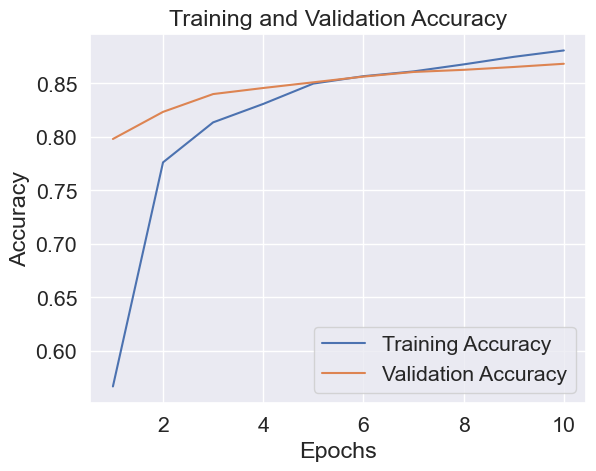

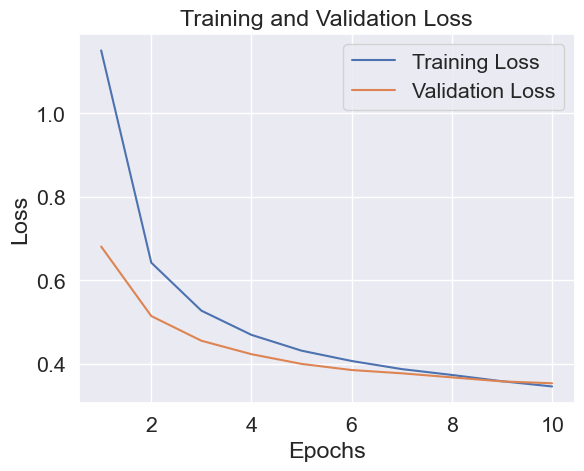

In [37]:
plot_accuracy_loss(result)

In [38]:
test_loss, test_acc = modelVGG.evaluate(test_features, test_labels, verbose=0)
print("Test loss and accuracy of modelVGG:", test_loss, test_acc)


Test loss and accuracy of modelVGG: 0.35305649042129517 0.8683333396911621


We gained maximum 87% accuracy using pre-trained model VGG16, which is higher than previous model.

Thus by using more dense CNN layers with dense layers we can get higher accuracy when more information of every image needs to be captured.

# 6. Train neurons separately
Define numbers of samples on which to train each neuron.

In [39]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [40]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [42]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], 
                                   batch_size=128, epochs=5, validation_split = 0.1))

Epoch 1/5
79/79 [==============================] - 0s 5ms/step - loss: 0.2269 - accuracy: 0.9209 - val_loss: 0.2190 - val_accuracy: 0.9216
Epoch 2/5
79/79 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9513 - val_loss: 0.1881 - val_accuracy: 0.9368
Epoch 3/5
79/79 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.9709 - val_loss: 0.1772 - val_accuracy: 0.9457
Epoch 4/5
79/79 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9803 - val_loss: 0.1602 - val_accuracy: 0.9510
Epoch 5/5
79/79 [==============================] - 0s 4ms/step - loss: 0.0550 - accuracy: 0.9879 - val_loss: 0.1741 - val_accuracy: 0.9519
Epoch 1/5
79/79 [==============================] - 0s 5ms/step - loss: 0.2372 - accuracy: 0.9181 - val_loss: 0.1891 - val_accuracy: 0.9368
Epoch 2/5
79/79 [==============================] - 0s 6ms/step - loss: 0.1215 - accuracy: 0.9613 - val_loss: 0.1738 - val_accuracy: 0.9421
Epoch 3/5
79/79 [==========

## Aggregate each models predictions

In [43]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 0s 1ms/step


### Because we now have a lower variance we produce a better result 89% up from 70%

In [44]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8883333333333333


### Resources:
##### Basics on CNN, reading and preparing data, some visualization 
https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte
##### Error analysis, some visualizations, basic model creations, train neurons separately
https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras
##### Transfer learning, model improvement
https://www.kaggle.com/code/avikumart/computervision-intel-image-classification-project

